EXP 7

Epoch 100, Generator Loss: 0.46580448746681213, Discriminator Loss: 1.2143131494522095


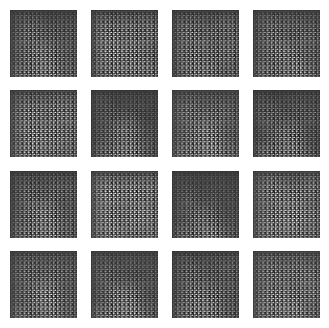

Epoch 200, Generator Loss: 1.1641753911972046, Discriminator Loss: 0.7846460342407227


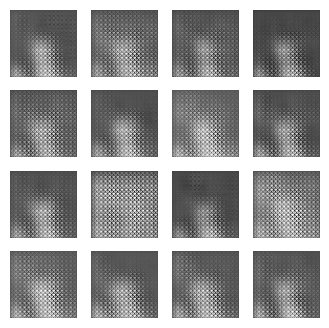

Epoch 300, Generator Loss: 2.0415468215942383, Discriminator Loss: 0.35064759850502014


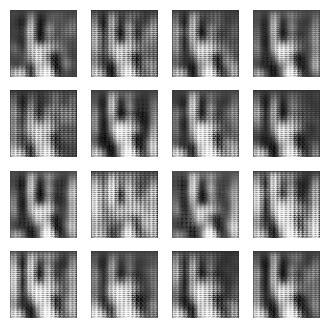

Epoch 400, Generator Loss: 1.5118372440338135, Discriminator Loss: 0.9698069095611572


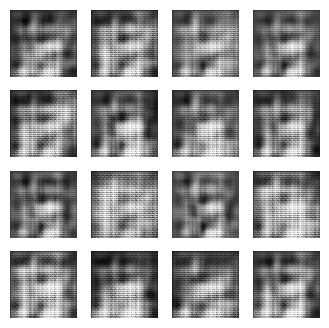

Epoch 500, Generator Loss: 5.130905628204346, Discriminator Loss: 0.5079693794250488


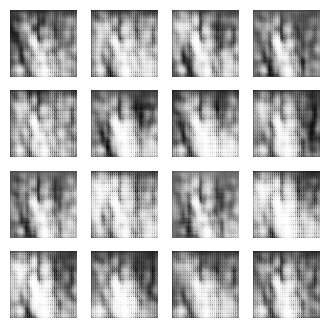

Epoch 600, Generator Loss: 1.148594617843628, Discriminator Loss: 0.8170307874679565


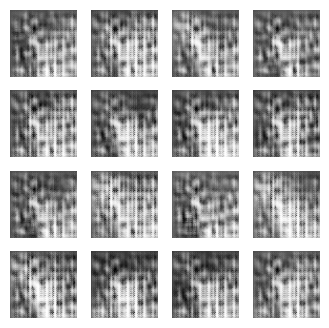

Epoch 700, Generator Loss: 1.0252307653427124, Discriminator Loss: 1.4107587337493896


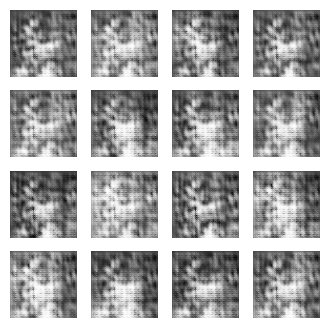

Epoch 800, Generator Loss: 1.5146567821502686, Discriminator Loss: 0.7911469340324402


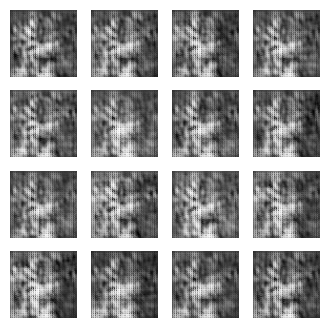

Epoch 900, Generator Loss: 0.8957593441009521, Discriminator Loss: 1.7560334205627441


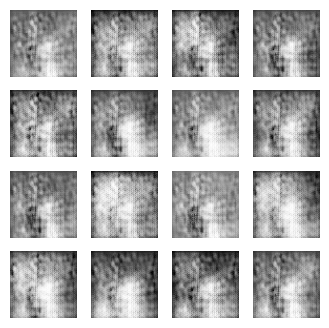

Epoch 1000, Generator Loss: 0.78117835521698, Discriminator Loss: 1.0637259483337402


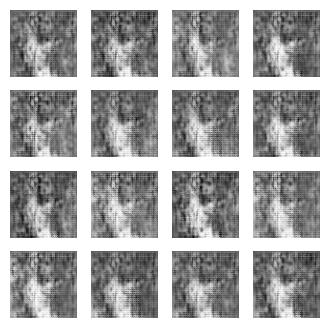

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

image_folder = '/content/drive/MyDrive/DATA'
image_size = (64, 64)
images = []

for filename in os.listdir(image_folder):
    if filename.endswith(".jpeg") or filename.endswith(".jpg"):
        img = Image.open(os.path.join(image_folder, filename)).resize(image_size).convert('L')
        img = np.array(img) / 255.0
        images.append(img)

images = np.array(images).reshape(-1, image_size[0], image_size[1], 1)

def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def train(generator, discriminator, dataset, epochs=1000):
    for epoch in range(epochs):
        for real_images in dataset:
            batch_size = real_images.shape[0]


            noise = tf.random.normal([batch_size, 100])
            fake_images = generator(noise)


            real_labels = tf.ones((batch_size, 1))
            fake_labels = tf.zeros((batch_size, 1))


            with tf.GradientTape() as tape:
                real_output = discriminator(real_images)
                fake_output = discriminator(fake_images)
                disc_loss = loss_fn(real_labels, real_output) + loss_fn(fake_labels, fake_output)
            gradients = tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))


            noise = tf.random.normal([batch_size, 100])
            with tf.GradientTape() as tape:
                fake_images = generator(noise)
                fake_output = discriminator(fake_images)
                gen_loss = loss_fn(real_labels, fake_output)
            gradients = tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")
            generate_and_save_images(generator, epoch + 1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'/content/epoch_{epoch}.png')
    plt.show()
BATCH_SIZE = 32
noise_dim = 100
seed = tf.random.normal([16, noise_dim])

train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1024).batch(BATCH_SIZE)
train(generator, discriminator, train_dataset, epochs=1000)


EXP 6

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from sklearn.model_selection import train_test_split


english_sentences = ["hello", "world", "good morning"]
tamil_sentences = ["வணக்கம்", "உலகம்", "காலை வணக்கம்"]

tokenizer_en = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ta = tf.keras.preprocessing.text.Tokenizer()

tokenizer_en.fit_on_texts(english_sentences)
tokenizer_ta.fit_on_texts(tamil_sentences)


input_sequences = tokenizer_en.texts_to_sequences(english_sentences)
target_sequences = tokenizer_ta.texts_to_sequences(tamil_sentences)

input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, padding='post')
target_sequences = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, padding='post')

vocab_size_en = len(tokenizer_en.word_index) + 1
vocab_size_ta = len(tokenizer_ta.word_index) + 1

x_train, x_val, y_train, y_val = train_test_split(input_sequences, target_sequences, test_size=0.2)


embedding_dim = 64
units = 128
encoder_input = Input(shape=(None,))
encoder_emb = Embedding(vocab_size_en, embedding_dim)(encoder_input)
encoder_output, state_h, state_c = LSTM(units, return_state=True)(encoder_emb)


decoder_input = Input(shape=(None,))
decoder_emb = Embedding(vocab_size_ta, embedding_dim)(decoder_input)
decoder_lstm = LSTM(units, return_sequences=True)(decoder_emb, initial_state=[state_h, state_c])
decoder_output = Dense(vocab_size_ta, activation='softmax')(decoder_lstm)


model = Model([encoder_input, decoder_input], decoder_output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit([x_train, y_train[:, :-1]], y_train[:, 1:], validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]), epochs=10)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 1.3825 - val_accuracy: 1.0000 - val_loss: 1.3755
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 1.3667 - val_accuracy: 1.0000 - val_loss: 1.3665
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 1.3509 - val_accuracy: 1.0000 - val_loss: 1.3574
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 1.3347 - val_accuracy: 1.0000 - val_loss: 1.3480
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 1.3180 - val_accuracy: 1.0000 - val_loss: 1.3383
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 1.3007 - val_accuracy: 1.0000 - val_loss: 1.3281
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 1.2825 - val_accuracy: 1.0000 - val_loss: 1.3174
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.2634 - val_accuracy: 1.0000 - val_loss: 1.3062
Epoc

EXP 6

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Bidirectional

# Sample data
sentences = [
    "I like dogs",
    "You love cats",
    "We hate snakes"
]
pos_tags = [
    "PRON VERB NOUN",
    "PRON VERB NOUN",
    "PRON VERB NOUN"
]

# Step 1: Tokenize sentences and POS tags
sentence_tokenizer = Tokenizer(lower=True, oov_token="<UNK>")
sentence_tokenizer.fit_on_texts(sentences)

tag_tokenizer = Tokenizer(lower=False)  # Tags are case-sensitive
tag_tokenizer.fit_on_texts(pos_tags)

# Convert sentences and tags to sequences
X = sentence_tokenizer.texts_to_sequences(sentences)
y = tag_tokenizer.texts_to_sequences(pos_tags)

# Pad sequences
max_len = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_len, padding='post')
y_padded = pad_sequences(y, maxlen=max_len, padding='post')

# Convert tags to one-hot encoding
y_categorical = np.array([to_categorical(seq, num_classes=len(tag_tokenizer.word_index) + 1) for seq in y_padded])

# Step 2: Define the model
embedding_dim = 64
hidden_units = 64

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_layer)
lstm_layer = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(embedding_layer)
output_layer = TimeDistributed(Dense(len(tag_tokenizer.word_index) + 1, activation='softmax'))(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the model
model.fit(X_padded, y_categorical, epochs=10, batch_size=32)

# Step 4: Predict
test_sentence = "I love birds"
test_seq = pad_sequences(sentence_tokenizer.texts_to_sequences([test_sentence]), maxlen=max_len, padding='post')

predictions = model.predict(test_seq)
pred_tags = np.argmax(predictions, axis=-1)

# Decode predictions to POS tags
decoded_tags = [[tag_tokenizer.index_word[idx] for idx in seq] for seq in pred_tags]
print(f"Test Sentence: {test_sentence}")
print(f"Predicted POS tags: {decoded_tags[0][:len(test_sentence.split())]}")


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1111 - loss: 1.3868
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2222 - loss: 1.3813
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5556 - loss: 1.3758
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5556 - loss: 1.3703
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6667 - loss: 1.3646
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6667 - loss: 1.3587
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6667 - loss: 1.3526
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6667 - loss: 1.3463
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6667 - loss: 1.3396
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6667 - loss: 1.3325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Test Sentence: I love birds
Predicted POS tags: ['PRON', 'PRON', 'NOUN']


EXP 5B

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# Load dataset
df = pd.read_csv("tweets_dataset.csv")
df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'tweets','Positive':'sentiment'})

# Replace with your dataset file name
df = df[['tweets', 'sentiment']]

# Encode sentiments
label_encoder = LabelEncoder()

# Tokenization and padding
max_words = 5000  # Vocabulary size
max_len = 50      # Maximum length of a tweet

# Drop null values
df = df.dropna()

# Ensure all values in the 'tweets' column are strings
df['tweets'] = df['tweets'].astype(str)

# Encode the 'sentiment' column
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Tokenize the 'tweets' column (without the <OOV> token)
tokenizer = Tokenizer(num_words=max_words)  # Remove oov_token parameter
tokenizer.fit_on_texts(df['tweets'])
sequences = tokenizer.texts_to_sequences(df['tweets'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')


# Split data
X = padded_sequences
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes: positive, negative, neutral
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Predicting on new tweets
def predict_sentiment(tweet):
    sequence = tokenizer.texts_to_sequences([tweet])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    prediction = model.predict(padded)
    sentiment_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment_label[0]

# Example

example_tweet = "Hii"
predicted_sentiment = predict_sentiment(example_tweet)
print(f"Predicted Sentiment: {predicted_sentiment}")

EXP 4B

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

# Load the dataset
medium_data = pd.read_csv("/content/medium_data-Copy1 - medium_data-Copy1.csv")

# Clean the 'title' column
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0', u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a', ' '))

# Tokenize the titles
tokenizer = Tokenizer(oov_token='<OOV>', num_words=10000)
tokenizer.fit_on_texts(medium_data['title'])

# Create sequences for training
total_words = len(tokenizer.word_index) + 1
input_sequences = []

for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad the sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Split data into features and labels
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=128, input_length=max_sequence_len - 1))
model.add(Bidirectional(GRU(200, return_sequences=False)))
model.add(Dense(256, activation='relu'))
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(xs, ys, epochs=10, verbose=1, batch_size=64)

# Generate new text
seed_text = "A Beginner's Guide"
next_words = 5

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break
    seed_text += " " + output_word

# Print the generated text
print(seed_text)


EXP 4A

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Input text
text = """
It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. However little
known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding
Joel Ebenezer P - 715522243021
families, that he is considered the rightful property of some one or other of their daughters.
"""

# Step 1: Tokenize the entire text
tokenizer = Tokenizer(lower=True, oov_token="<UNK>")
tokenizer.fit_on_texts([text])

# Convert the text to sequences
token_list = tokenizer.texts_to_sequences([text])[0]

# Step 2: Generate n-gram sequences
input_sequences = []
for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i + 1]
    input_sequences.append(n_gram_sequence)

# Step 3: Pad sequences and prepare training data
max_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1)

# Step 4: Define the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 64, input_length=max_len - 1))
model.add(LSTM(100))
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Step 5: Train the model
model.fit(X, y, epochs=100, verbose=1)

# Step 6: Generate new text
seed_text = "It is a truth"
next_words = 10

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_len - 1, padding='pre')
    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
    output_word = tokenizer.index_word[predicted[0]]
    seed_text += " " + output_word

print(f"Generated text: {seed_text}")


EXP 3 A

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

# Data directory
data_dir = r"F:\lfw_facedata\lfw-deepfunneled\lfw-deepfunneled"

# Data augmentation and loading
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# Training data
train_data = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data
val_data = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Model definition
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer with 5749 classes
model.add(layers.Dense(5749, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, validation_data=val_data, epochs=2)


EXP 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Reshape and normalize the data
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32') / 255.0
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32') / 255.0

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Display an example image from the training dataset
plt.imshow(X_train[1000].reshape(28, 28), cmap='gray')
plt.title(f'Label: {y_train[1000]}')
plt.axis('off')
plt.show()

# Model Definition
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Evaluate the model on the training data
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Predict on test data
result = model.predict(X_test)
y_pred = np.argmax(result, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


EXP **5**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

data = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

texts = data['review'].values
labels = data['sentiment'].values

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

max_vocab_size = 5000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=64, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(set(labels)), activation=sigmoid))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=7, validation_data=(X_test, y_test), batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

def predict_emotion(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_sequence_length, padding='post')

    prediction = model.predict(input_padded)
    predicted_class = np.argmax(prediction, axis=1)

    emotion_label = label_encoder.inverse_transform(predicted_class)

    return emotion_label[0]
